<a href="https://colab.research.google.com/github/kasev/PIA/blob/master/scripts/OVERVIEW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
### PREREQUISTIES
### (many used only in one notebook...)

import os
import pandas as pd
import numpy as np
import logging ### to monitor the code
from bs4 import BeautifulSoup
import pickle
import math
import random
import sys
import csv
import unicodedata
import requests
import re

import nltk
from nltk.collocations import *

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import xml.etree.cElementTree as ET
from urllib.request import urlopen

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.colab import auth
from oauth2client.client import GoogleCredentials

!pip install sddk
import sddk

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#!pip install anda
#from anda import gr ### the import takes substantial time, since it import a +600MB file containing ancient Greek dictionary

     |████████████████████████████████| 21.3MB 1.4MB/s 


In [ ]:
### not neccessary for reading the data, just for exporting them to sciencedata.dk
conf = sddk.configure()

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ··········
endpoint variable has been configured to: https://sciencedata.dk/files/


In [ ]:
### authorize google sheets
auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())
# establish connection with particular sheet by its url:

PIA_data = gc.open_by_url("https://docs.google.com/spreadsheets/d/1KxOx7Be9fj3lDcEPgQhQ-Iqcn9p367-MMD6RMXe8rks/edit?usp=sharing")
PIA_overview = gc.open_by_url("https://docs.google.com/spreadsheets/d/1e94wyelg6dftQ4zxbq1xvwxWAI-BhcYXtclDW-YTnrw/edit?usp=sharing")

In [ ]:
### our data are located within a publicly available folder on sciencedata.dk
publicfolder = "31b393e2afe1ee96ce81869c7efe18cb"
c_aristotelicum = sddk.read_file("c_aristotelicum_repl.json", "df", publicfolder)
c_hippocraticum = sddk.read_file("c_hippocraticum_repl.json", "df", publicfolder)

this file is located in a public folder
this file is located in a public folder


In [ ]:
keyterm_patterns = [("^λ[υ|ύ]π.+", "λύπ*"), ("^[ἀ|ἄ]λγ.+", "ἄλγ*"), ("^[ὀ|ὠ]δ[ύ|υ]ν.", "ὀδύν*"), ("^π[ό|ο]ν[ο|ό|έ|ε|η|ή|ῆ](?!ρ).+", "πόνο*")]

In [ ]:
# make overview columns of individual terms accross documents
for pattern_tuple in keyterm_patterns:
  term = pattern_tuple[1] # eg. "λύπ*"
  c_aristotelicum[term] =  c_aristotelicum.apply(lambda row: row["lemmata_repl"].count(term), axis=1)
  c_hippocraticum[term] =  c_hippocraticum.apply(lambda row: row["lemmata_repl"].count(term), axis=1)

In [ ]:
c_aristotelicum[["λύπ*", "ἄλγ*", "ὀδύν*", "πόνο*"]].sum()

λύπ*     391
ἄλγ*      32
ὀδύν*      3
πόνο*    100
dtype: int64

In [ ]:
c_hippocraticum[["λύπ*", "ἄλγ*", "ὀδύν*", "πόνο*"]].sum()

λύπ*      58
ἄλγ*     315
ὀδύν*    642
πόνο*    651
dtype: int64

In [ ]:
# what columns we have
# (which columns to drop while exporting to gsheet - "string" etc. contain large data)
print(list(c_aristotelicum.columns))

['filename', 'author', 'title', 'string', 'author_id', 'doc_id', 'raw_date', 'date_avr', 'date_probs', 'date_manual', 'provenience', 'wordcount', 'lemmata', 'lemmatized_sentences', 'lemmata_wordcount', 'num_of_sents', 'lemmata_repl', 'lemmatized_sentences_repl', 'λύπ*', 'ἄλγ*', 'ὀδύν*', 'πόνο*']


In [ ]:
# uncomment to export overview data to gsheet
set_with_dataframe(PIA_overview.add_worksheet("c_aristotelicum_20200814",1,1), c_aristotelicum.drop(['string','lemmata', 'lemmatized_sentences', 'lemmatized_sentences_repl', 'lemmata_repl'], axis=1))
set_with_dataframe(PIA_overview.add_worksheet("c_hippocraticum_20200814",1,1), c_hippocraticum.drop(['string','lemmata', 'lemmatized_sentences', 'lemmatized_sentences_repl', 'lemmata_repl'], axis=1))

In [ ]:
for term in ["λύπ*", "ἄλγ*", "ὀδύν*",	"πόνο*"]:
  c_aristotelicum[term + "_weighted"] = c_aristotelicum.apply(lambda row: row[term] / row["lemmata_wordcount"], axis=1)
  c_hippocraticum[term + "_weighted"] = c_hippocraticum.apply(lambda row: row[term] / row["lemmata_wordcount"], axis=1)
c_aristotelicum["weighted_sum"] = c_aristotelicum.apply(lambda row: (row["λύπ*"] + row["ἄλγ*"] + row["ὀδύν*"] + row["πόνο*"]) / row["lemmata_wordcount"], axis=1)
c_hippocraticum["weighted_sum"] = c_hippocraticum.apply(lambda row: (row["λύπ*"] + row["ἄλγ*"] + row["ὀδύν*"] + row["πόνο*"]) / row["lemmata_wordcount"], axis=1)

In [ ]:
c_aristotelicum

,filename,author,title,string,author_id,doc_id,raw_date,date_avr,date_probs,date_manual,provenience,wordcount,lemmata,lemmatized_sentences,lemmata_wordcount,num_of_sents,lemmata_repl,lemmatized_sentences_repl,λύπ*,ἄλγ*,ὀδύν*,πόνο*,λύπ*_weighted,ἄλγ*_weighted,ὀδύν*_weighted,πόνο*_weighted,weighted_sum
678,tlg0086.tlg001.1st1K-grc2.xml,Aristotle,Aristotelis Analytica Priora et Posteriora; Ar...,ΑΝΑΛΥΤΙΚΩΝ ΠΡΟΤΕΡΩΝ Α. Πρῶτον εἰπεῖν περὶ τί κ...,tlg0086,tlg0086.tlg001,4 B.C.,-3.5,{'-3.5': 1},-3.5,pagan,59772,"[αναλυτικων, πρότερος, πρότερος, εἶπον, σκέψις...","[[αναλυτικων, πρότερος], [πρότερος, εἶπον, σκέ...",21150,3645,"[αναλυτικων, πρότερος, πρότερος, εἶπον, σκέψις...","[[αναλυτικων, πρότερος], [πρότερος, εἶπον, σκέ...",0,1,0,0,0.000000,0.000047,0.000000,0.000000,0.000047
679,tlg0086.tlg002.1st1K-grc2.xml,Aristotle,De anima; Aritoteles De anima,ΠEP1 ΨΥΧΗΣ Α Τῶν καλῶν καὶ τιμίων τὴν εἴδησιν ...,tlg0086,tlg0086.tlg002,4 B.C.,-3.5,{'-3.5': 1},-3.5,pagan,20988,"[ψυχή, κᾶλον, τίμιος, εἶδος, μαλλός, ἕτερος, ἕ...","[[ψυχή, κᾶλον, τίμιος, εἶδος, μαλλός, ἕτερος, ...",8893,1306,"[ψυχή, κᾶλον, τίμιος, εἶδος, μαλλός, ἕτερος, ἕ...","[[ψυχή, κᾶλον, τίμιος, εἶδος, μαλλός, ἕτερος, ...",12,0,0,0,0.001349,0.000000,0.000000,0.000000,0.001349
681,tlg0086.tlg005.1st1K-grc1.xml,Aristotle,De caelo; Aristoteles De coelo et De generatio...,ΠEPI ΟΥΡΑΝΟΥ A. Ἡ περὶ φύσεως ἐπιστήμη σχεδὸν ...,tlg0086,tlg0086.tlg005,4 B.C.,-3.5,{'-3.5': 1},-3.5,pagan,31395,"[οὐρανός, φύσις, ἐπιστήμη, πλεῖστος, φαίνω, σῶ...","[[οὐρανός], [φύσις, ἐπιστήμη, πλεῖστος, φαίνω,...",12915,1986,"[οὐρανός, φύσις, ἐπιστήμη, πλεῖστος, φαίνω, σῶ...","[[οὐρανός], [φύσις, ἐπιστήμη, πλεῖστος, φαίνω,...",0,0,0,1,0.000000,0.000000,0.000000,0.000077,0.000077
682,tlg0086.tlg006.1st1K-grc1.xml,Aristotle,Categoriae; Aristotelis Opera,ΚΑΤΗΓΟΡΙΑΙ. ὉΜΩΝΥΜΑ λέγεται ὧν ὄνομα μόνον κοι...,tlg0086,tlg0086.tlg006,4 B.C.,-3.5,{'-3.5': 1},-3.5,pagan,10317,"[κατηγορία, ὁμωνυμα, λέγω, ὄνομα, μόνος, κοινό...","[[κατηγορία], [ὁμωνυμα, λέγω, ὄνομα, μόνος, κο...",4372,659,"[κατηγορία, ὁμωνυμα, λέγω, ὄνομα, μόνος, κοινό...","[[κατηγορία], [ὁμωνυμα, λέγω, ὄνομα, μόνος, κο...",2,0,0,0,0.000457,0.000000,0.000000,0.000000,0.000457
683,tlg0086.tlg008.1st1K-grc1.xml,Aristotle,De divinatione per somnum; Aristotelis Opera,ΠΕΡΙ ΕΝΥΠΝΙΩΝ ΚΑΙ ΤΗΣ ΚΑΘ’ ΥΠΝΟΝ ΜΑΝΤΙΚΗΣ. Περ...,tlg0086,tlg0086.tlg008,4 B.C.,-3.5,{'-3.5': 1},-3.5,pagan,1207,"[ἐνύπνιον, ἀκή, ἄατος, ὕπνος, μαντικός, μαντικ...","[[ἐνύπνιον, ἀκή, ἄατος, ὕπνος, μαντικός], [μαν...",533,69,"[ἐνύπνιον, ἀκή, ἄατος, ὕπνος, μαντικός, μαντικ...","[[ἐνύπνιον, ἀκή, ἄατος, ὕπνος, μαντικός], [μαν...",0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000
684,tlg0086.tlg009.perseus-grc1.xml,Aristotle,Eudemian Ethics (Greek). Machine readable text...,ὁ μὲν ἐν Δήλῳ παρὰ τῷ θεῷ τὴν αὑτοῦ γνώμην ἀπο...,tlg0086,tlg0086.tlg009,4 B.C.,-3.5,{'-3.5': 1},-3.5,pagan,26361,"[δῆλος, θεός, γνώμη, συγγράφω, προπύλαιος, Λητ...","[[δῆλος, θεός, γνώμη, συγγράφω, προπύλαιος, Λη...",11158,1676,"[δῆλος, θεός, γνώμη, συγγράφω, προπύλαιος, Λητ...","[[δῆλος, θεός, γνώμη, συγγράφω, προπύλαιος, Λη...",72,3,1,7,0.006453,0.000269,0.000090,0.000627,0.007439
685,tlg0086.tlg010.perseus-grc1.xml,Aristotle,Nicomachean Ethics; Machine readable text; ed....,"βοοκ 1 πᾶσα τέχνη καὶ πᾶσα μέθοδος, ὁμοίως δὲ ...",tlg0086,tlg0086.tlg010,4 B.C.,-3.5,{'-3.5': 1},-3.5,pagan,56638,"[βοοκ, πᾶς, τέχνη, πᾶς, μέθοδος, ὅμοιος, πρᾶξί...","[[βοοκ, πᾶς, τέχνη, πᾶς, μέθοδος, ὅμοιος, πρᾶξ...",23811,3897,"[βοοκ, πᾶς, τέχνη, πᾶς, μέθοδος, ὅμοιος, πρᾶξί...","[[βοοκ, πᾶς, τέχνη, πᾶς, μέθοδος, ὅμοιος, πρᾶξ...",148,6,0,11,0.006216,0.000252,0.000000,0.000462,0.006930
687,tlg0086.tlg014.1st1K-grc1.xml,Aristotle,Historia animalium; Aristotelis Opera,ΠΕΡΙ ΤΑ ΖΩΙΑ ΙΣΤΟΡΙΩΝ Α. ΤΩΝ ἐν τοῖς ζῴοις μορ...,tlg0086,tlg0086.tlg014,4 B.C.,-3.5,{'-3.5': 1},-3.5,pagan,94068,"[ζωια, ἱστορία, ζῷον, μορία, ἀσύνθετος, ὅσος, ...","[[ζωια, ἱστορία], [ζῷον, μορία, ἀσύνθετος, ὅσο...",43435,6345,"[ζωια, ἱστορία, ζῷον, μορία, ἀσύνθετος, ὅσος, ...","[[ζωια, ἱστορία]

AttributeError: ignored

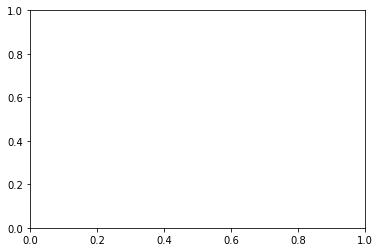

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
viridis = plt.get_cmap('coolwarm')


labels = [title.partition(";")[0].partition(".")[0] for title in c_aristotelicum["title"].tolist()]
lemmata_wordcounts_1 = c_aristotelicum["wordcount"]
lemmata_wordcounts_2 = c_aristotelicum["wordcount"]
lype = c_aristotelicum["λύπ*_weighted"].tolist()

y = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

#fig, ax = plt.subplots(figsize=(12, 8), tight_layout=True)
rects1 = plt.barh(x - width/2, lemmata_wordcounts_1, width, label='Men', c=lype, cmap="viridis")
#rects2 = ax.barh(x + width/2, lemmata_wordcounts_1, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
#ax.set_xlabel("wordcount")
#ax.set_ylabel("documents")
#ax.set_title("Documents by wordcount")
#ax.set_yticks(y)
#ax.set_yticklabels(labels)
#ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


#autolabel(rects1)
#autolabel(rects2)

fig.tight_layout()

plt.show()